In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.mixed_precision import experimental as mixed_precision

from tensorflow.keras.callbacks import Callback

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

import pydicom



In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
BATCH_SIZE = 16
IMG_HEIGHT = 512
IMG_WIDTH = 512
epochs = 2
lr = 3e-4

In [4]:
val_data_dir = '/opt/AIStorage/PLAYGROUND/DICOMS/validation'
val_data_dir = pathlib.Path(val_data_dir)

data_dir = '/opt/AIStorage/PLAYGROUND/DICOMS/train'
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.dcm')))
image_count

3200

In [6]:
val_image_count = len(list(val_data_dir.glob('*/*.dcm')))
val_image_count

799

In [7]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

val_list_ds = tf.data.Dataset.list_files(str(val_data_dir/'*/*'))

In [8]:
list_ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [9]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  label = -1
  if parts[-2] == 'negative':
    label = tf.constant([1.0, 0.0])
  else:
    label = tf.constant([0.0, 1.0])
  return label

In [10]:
def decode_img(img):
  print('type2',type(img))
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [11]:
def extract_dicom_data(file_path):
    ds = pydicom.dcmread(file_path)
    pix = ds.pixel_array
    print('pix', pix)
    print('type',type(pix))
    print('shape', pix.shape)
    return tf.Tensor(pix)

In [17]:
def pixel_bytes(file_path):
    ds = pydicom.dcmread(file_path)
    pix = ds.PixelData
    return pix

In [18]:
def process_path(file_path):
  print('path',file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  #img = tf.io.read_file(file_path)
  img = tf.py_function(pixel_bytes, [file_path], Tout=[tf.uint8])
  print('img',img)
  img = decode_img(img)
  return img, label

In [19]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_labeled_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

path Tensor("args_0:0", shape=(), dtype=string)
img [<tf.Tensor 'EagerPyFunc:0' shape=<unknown> dtype=uint8>]
type2 <class 'list'>


ValueError: in converted code:

    <ipython-input-15-abb0dc7670d3>:8 process_path  *
        img = decode_img(img)
    <ipython-input-10-f665f37dd2ec>:6 decode_img  *
        return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    /home/HEALTH/ejguillen/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow_core/python/ops/image_ops_impl.py:1319 resize_images_v2
        skip_resize_if_same=False)
    /home/HEALTH/ejguillen/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow_core/python/ops/image_ops_impl.py:1034 _resize_images_common
        raise ValueError('\'images\' contains no shape.')

    ValueError: 'images' contains no shape.


In [ ]:
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.ceil(val_image_count/BATCH_SIZE)

In [ ]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

In [ ]:
for image, label in val_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

In [ ]:
def prepare_for_training(ds, shuffle=True, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  if shuffle:
    ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [ ]:
train_ds = prepare_for_training(labeled_ds)

valid_ds = prepare_for_training(val_labeled_ds, shuffle=False)
#valid_ds = val_labeled_ds

image_batch, label_batch = next(iter(train_ds))

In [ ]:
class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
 

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            print('get lr error')
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            print('get momentum error')
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            print('set lr error')
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            print('set momentum error')
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with mirrored_strategy.scope():
    steps = np.ceil(image_count / BATCH_SIZE) * epochs
    lr_schedule = OneCycleScheduler(lr, steps)

    optimizer = tf.keras.optimizers.SGD(lr=lr)
    #optimizer = tf.keras.optimizers.RMSprop(lr=lr)
    #optimizer = tf.keras.optimizers.Adam()
    IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
    base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    base_model.trainable = False
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    batch_norm_1 = tf.keras.layers.BatchNormalization()
    drop_out_1 = tf.keras.layers.Dropout(0.5)
    dense_layer_1 = tf.keras.layers.Dense(1024,activation='relu')

    batch_norm_2 = tf.keras.layers.BatchNormalization()
    drop_out_2 = tf.keras.layers.Dropout(0.25)
    prediction_layer = tf.keras.layers.Dense(2)

    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      
      batch_norm_1,
      drop_out_1,
      dense_layer_1,
      
      batch_norm_2,
      drop_out_2,
      prediction_layer
    ])

    
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])
    
    model.summary()
    
    history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=valid_ds, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VAL_STEPS_PER_EPOCH,
                    callbacks=[lr_schedule])

In [ ]:
lr_schedule.plot()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
!ls /opt/AIStorage/PLAYGROUND/DICOMS/train/positive

2.25.10026350508920581228173829402070121007.dcm
2.25.10027690334575557067687917824105703402.dcm
2.25.100318324570098234668238175176818040373.dcm
2.25.100387978963132338813898919537082572050.dcm
2.25.100785857589673458106415803638374481700.dcm
2.25.100837548008706622626275972530760793636.dcm
2.25.101083701781909257927693772328905154868.dcm
2.25.101215591125224838888388620435002112060.dcm
2.25.101317953664844438739117607683604375431.dcm
2.25.101394293196901537902708991230088452470.dcm
2.25.101425167187817724018454064739792667799.dcm
2.25.101508737014988371433308551568838299596.dcm
2.25.101517080580534120902693059028195785606.dcm
2.25.10167086313035618218116817664972248370.dcm
2.25.101711870490358856261574669454280337125.dcm
2.25.10172154613001018398888169708854038861.dcm
2.25.101820265901865532163090531088706189493.dcm
2.25.102050279146557971233708370017165920660.dcm
2.25.102472091652912652654480505567127119863.dcm
2.25.10263685214314727651951544779147319565.dcm
2.25.10267923134593345772

Automatically created module for IPython interactive environment

Filename.........: /opt/AIStorage/PLAYGROUND/DICOMS/train/positive/2.25.107148589782783917974253699379373119903.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.1

Patient's name...: Galloway, Cletus
Patient id.......: STAI-00000682
Modality.........: CR
Study Date.......: 20160729
Image size.......: 4280 x 3520, 30131200 bytes
Pixel spacing....: [0.10, 0.10]
Slice location...: (missing)


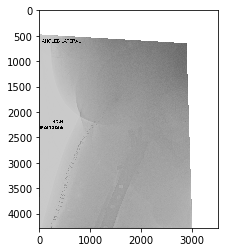

In [34]:
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files

print(__doc__)

filename = '/opt/AIStorage/PLAYGROUND/DICOMS/train/positive/2.25.107148589782783917974253699379373119903.dcm'
dataset = pydicom.dcmread(filename)

# Normal mode:
print()
print("Filename.........:", filename)
print("Storage type.....:", dataset.SOPClassUID)
print()

pat_name = dataset.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print("Patient's name...:", display_name)
print("Patient id.......:", dataset.PatientID)
print("Modality.........:", dataset.Modality)
print("Study Date.......:", dataset.StudyDate)

if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap='gray')
plt.show()

In [ ]:
dataset.pixel_array.shape